In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import time
import momepy

import os
import sys

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import src

## Load data

In [2]:
blocks = gpd.read_file('/home/edgaregurrola/Repos/odc/accesibilidad-urbana/data/raw/volvo/blocks_guadalajara.geojson')
print(blocks.shape)
blocks.head(2)

(57687, 9)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,1403900013020059,14,039,0001,3020,059,Urbana,Típica,"POLYGON ((-103.30625 20.71851, -103.30638 20.7..."
1,1403900013020058,14,039,0001,3020,058,Urbana,Típica,"POLYGON ((-103.30662 20.71869, -103.30672 20.7..."


In [3]:
crs = "EPSG:32613"
blocks = blocks.to_crs(crs)
blocks = blocks.copy()
blocks = blocks.dissolve().explode().reset_index() # eliminate overlaping polygons and multipolygon

In [4]:
print(blocks.shape)
blocks.head(2)

(56814, 10)


,index,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,0,1403900013020059,14,039,0001,3020,059,Urbana,Típica,"POLYGON ((654000.212 2261608.786, 653984.912 2..."
1,0,1403900013020059,14,039,0001,3020,059,Urbana,Típica,"POLYGON ((654125.516 2261743.398, 654130.665 2..."


<Axes: >

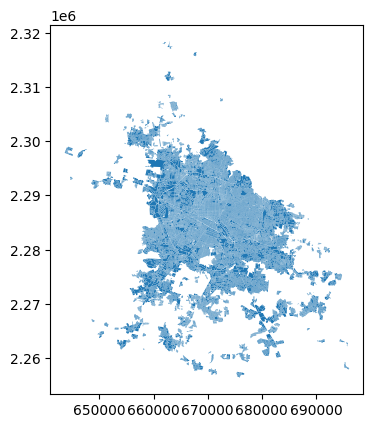

In [5]:
blocks.plot()

## Create tessellation

In [ ]:
tess = momepy.morphological_tessellation(blocks)
print(tess.shape)
tess.head(2)

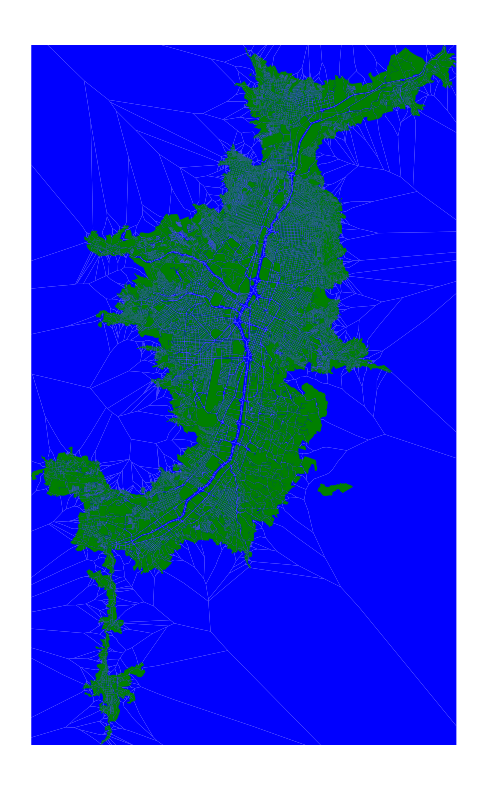

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
blocks.plot(ax=ax, color='g', zorder=1)
tess.plot(ax=ax, color='blue', markersize=5, zorder=0)
ax.set_axis_off()
plt.show()

## Polygons to lines

(18346, 1)


<Axes: >

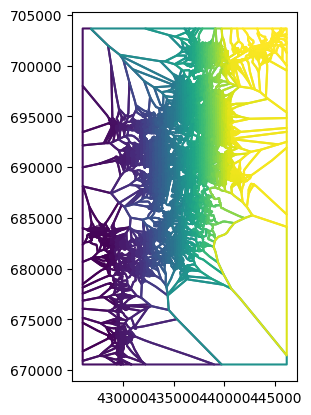

In [7]:
lines_gdf = gpd.GeoDataFrame(geometry=tess.geometry.boundary)
print(lines_gdf.shape)
lines_gdf.reset_index().plot('index')

## Lines to single lines

In [8]:
from shapely import ops

In [9]:
lines_gdf.dissolve().geometry.map(lambda x: ops.linemerge(x))

0    MULTILINESTRING ((427672.535 671396.558, 42668...
Name: geometry, dtype: geometry

In [10]:
lines_single = gpd.GeoDataFrame(geometry=lines_gdf.dissolve().geometry.map(lambda x: ops.linemerge(x)).explode())
lines_single = lines_single.set_crs("EPSG:32613")
lines_single = lines_single.reset_index(drop=True)
lines_single = lines_single.reset_index()
print(lines_single.shape)
lines_single.head(2)

(54956, 2)


,index,geometry
0,0,"LINESTRING (427672.535 671396.558, 426685.093 ..."
1,1,"LINESTRING (426042.967 670909.532, 426042.967 ..."


<Axes: >

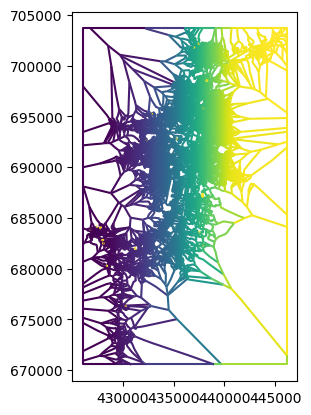

In [11]:
lines_single.plot('index')

## Extract vertices

In [12]:
from shapely.geometry import LineString, Point, Polygon

In [13]:
point_geo = [Point(lines_single.iloc[i].geometry.coords[0]) for i in range(len(lines_single))]

In [14]:
point_geo.extend([Point(lines_single.iloc[i].geometry.coords[-1]) for i in range(len(lines_single))])

In [15]:
len(point_geo)

109912

In [16]:
point_geo_filter = set(point_geo)
len(point_geo_filter)

36645

In [17]:
point_geo_filter = list(point_geo_filter)

Points to GeoDataFrame

In [18]:
import pandas as pd

nodes_gdf = pd.DataFrame(point_geo_filter)
nodes_gdf = nodes_gdf.rename(columns={0:'geometry'})
print(nodes_gdf.shape)
nodes_gdf.head(2)

(36645, 1)


,geometry
0,POINT (434749.5496946761 684847.4142814077)
1,POINT (429096.8901729628 682804.8521365428)


<Axes: >

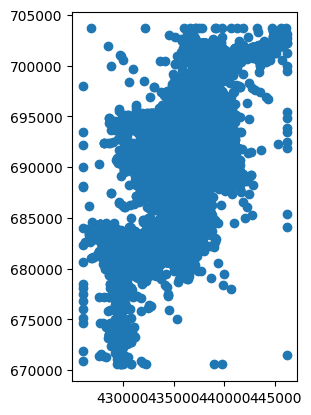

In [19]:
nodes_gdf = nodes_gdf.set_geometry('geometry')
nodes_gdf = nodes_gdf.set_crs("EPSG:32613")
nodes_gdf.plot()

## Create network

In [22]:
nodes, edges = src.network_entities(nodes_gdf, lines_single, crs="EPSG:32613")

In [23]:
print(nodes.shape)
nodes.head(2)

(36645, 3)


,geometry,x,y
osmid,,,
434749.5496946761684847.4142814077,POINT (434749.55 684847.414),434749.549695,684847.414281
429096.8901729628682804.8521365428,POINT (429096.89 682804.852),429096.890173,682804.852137


<Axes: >

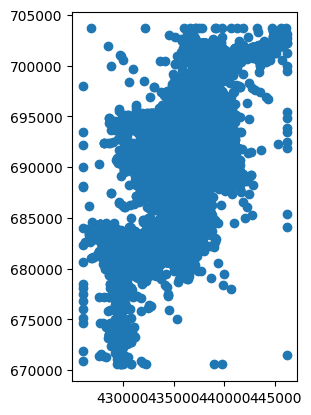

In [24]:
nodes.plot()

In [25]:
print(edges.shape)
edges.head(2)

(54956, 3)


,,,index,geometry,length
u,v,key,,,
427672.53497155494671396.5578676155,426042.96686000004670909.5319337558,0,0,"LINESTRING (427672.535 671396.558, 426685.093 ...",1700.789964
426042.96686000004670909.5319337558,426042.96686000004671851.7784948063,0,1,"LINESTRING (426042.967 670909.532, 426042.967 ...",942.246561


<Axes: >

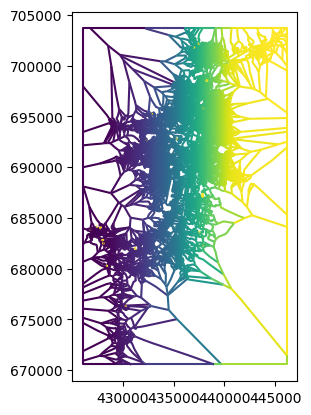

In [26]:
edges.plot('index')

## Check for duplicate data

In [37]:
edges.reset_index().duplicated(subset=['u','v','key']).sum()

np.int64(117)

In [35]:
nodes.reset_index().duplicated(subset=['osmid']).sum()

np.int64(0)

In [42]:
df = edges.reset_index()
df = df.sort_index()
grouped = df.groupby(['u', 'v', 'key'])
grouped

rows_to_drop = []
new_rows = []

for (u, v, key), group in grouped:
    if len(group) > 1:
        # Check if 'length' values are the same
        if group['length'].nunique() == 1:
            # If the 'length' is the same for all rows, drop the duplicates
            rows_to_drop.append(group.index[1:])  # Keep the first, drop the rest
        else:
            # If 'length' is different, increment the 'key' of the second row
            new_row = group.iloc[1].copy()  # Copy the second row
            new_row['key'] += 1  # Increment the key
            new_rows.append(new_row)
            rows_to_drop.append(group.index[1:])  # Drop the second row

In [47]:
def resolve_duplicates(df):
    # First, sort by index to ensure consistent grouping
    df = df.sort_index()
    
    # Identify duplicated entries based on the "u", "v", "key" indexes
    grouped = df.groupby(['u', 'v', 'key'])
    
    rows_to_drop = []
    new_rows = []
    
    for (u, v, key), group in grouped:
        if len(group) > 1:
            # Check if 'length' values are the same
            if group['length'].nunique() == 1:
                # If the 'length' is the same for all rows, drop the duplicates
                rows_to_drop.append(group.index[1:])  # Keep the first, drop the rest
            else:
                # If 'length' is different, increment the 'key' of the second row
                new_row = group.iloc[1].copy()  # Copy the second row
                new_row['key'] += 1  # Increment the key
                new_rows.append(new_row)
                rows_to_drop.append(group.index[1:])  # Drop the second row
    
    # Drop rows and add the new ones with incremented 'key'
    df = df.drop(pd.Index([index for sublist in rows_to_drop for index in sublist]))
    df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=False)
    
    return df.sort_index()

In [49]:
edges_test = resolve_duplicates(edges.reset_index())
edges_test = edges_test.set_index(['u','v','key'])

## Consolidate/simplify network

In [50]:
import osmnx as ox

Consolidate

In [51]:
nodes.shape

(36645, 3)

In [52]:
# nodes = nodes.to_crs("EPSG:4326")
# nodes['x'] = nodes.geometry.x
# nodes['y'] = nodes.geometry.y
# edges['length'] = edges.length
# edges = edges.to_crs("EPSG:4326")

In [53]:
print(nodes.shape)
nodes.head(2)

(36645, 3)


,geometry,x,y
osmid,,,
434749.5496946761684847.4142814077,POINT (434749.55 684847.414),434749.549695,684847.414281
429096.8901729628682804.8521365428,POINT (429096.89 682804.852),429096.890173,682804.852137


In [54]:
print(edges_test.shape)
edges_test.head(2)

(54956, 3)


,,,index,geometry,length
u,v,key,,,
427672.53497155494671396.5578676155,426042.96686000004670909.5319337558,0,0,"LINESTRING (427672.535 671396.558, 426685.093 ...",1700.789964
426042.96686000004670909.5319337558,426042.96686000004671851.7784948063,0,1,"LINESTRING (426042.967 670909.532, 426042.967 ...",942.246561


In [56]:
G = ox.graph_from_gdfs(nodes, edges_test)

AttributeError: 'NoneType' object has no attribute 'is_projected'

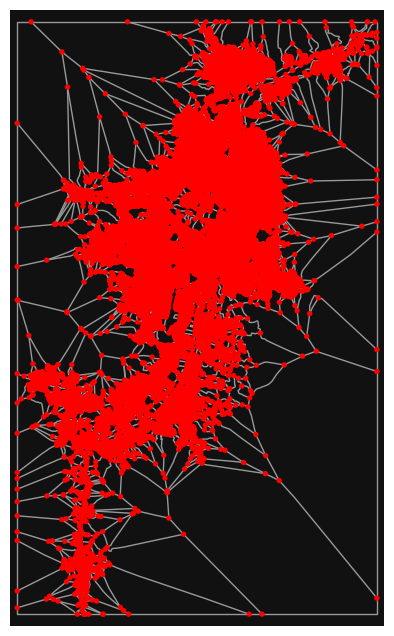

In [57]:
ox.plot_graph(G, node_color="r")

In [ ]:
# G_proj = ox.project_graph(G, to_crs="EPSG:32163")
G2 = ox.consolidate_intersections(G, rebuild_graph=True, tolerance=10, dead_ends=True)

In [ ]:
fig, ax = ox.plot_graph(G2, node_color="r")

In [ ]:
nodes_G2, edges_G2 = ox.graph_to_gdfs(G2)

In [ ]:
edges_G2

In [ ]:
nodes_G2

In [34]:
nodes_G2.to_file('../data/processed/nodes_consolidate_test.geojson')

In [35]:
edges_G2.to_file('../data/processed/edges_consolidate_test.geojson')

Simplify

In [40]:
G3 = ox.simplify_graph(G)
nodes_G3, edges_G3 = ox.graph_to_gdfs(G3)

In [41]:
nodes_G3

,x,y,geometry
osmid,,,
668045.008672288930.8658104907,-103.386521,20.692304,POINT (-103.38652 20.6923)
668045.008672288987.1832702826,-103.386515,20.692812,POINT (-103.38652 20.69281)
668226.50270360462288763.92282,-103.384795,20.690779,POINT (-103.38479 20.69078)
668246.87870886952288894.8493054775,-103.384587,20.691960,POINT (-103.38459 20.69196)
668045.008672289054.0821218835,-103.386509,20.693417,POINT (-103.38651 20.69342)
...,...,...,...
668828.950412289721.5808745036,-103.378920,20.699375,POINT (-103.37892 20.69937)
668828.950412289535.504191729,-103.378938,20.697694,POINT (-103.37894 20.69769)
668828.950412289645.111448182,-103.378928,20.698684,POINT (-103.37893 20.69868)


## Create function

In [3]:
import osmnx as ox
from shapely.geometry import LineString, Point, Polygon
from shapely import ops
import pandas as pd

In [4]:
def network_from_tessellation(gdf, crs):
    """
    Generates a road network graph from a tessellation of the provided geometric data.

    Args:
        gdf (geopandas.GeoDataFrame): A GeoDataFrame containing the initial polygons or multipolygons from which the tessellation 
        will be derived. These geometries will be processed to generate road network features.
    Returns:
        geopandas.GeoDataFrame: A GeoDataFrame containing the nodes (points) of the generated road network.
    
    geopandas.GeoDataFrame: A GeoDataFrame containing the edges (lines) of the generated road network.
    """
    # gdf preprocessing
    gdf = gdf.to_crs(crs)
    gdf = gdf.copy()
    gdf = gdf.dissolve().explode().reset_index() # eliminate overlaping polygons and multipolygon
    # create tessellation
    limit = momepy.buffered_limit(gdf, buffer=50)
    tess_gdf = momepy.morphological_tessellation(gdf, clip=limit)
    # polygons to lines
    lines_gdf = gpd.GeoDataFrame(geometry=tess_gdf.geometry.boundary)
    # separate lines by intersection
    lines_single = gpd.GeoDataFrame(geometry=lines_gdf.dissolve().geometry.map(lambda x: ops.linemerge(x)).explode())
    lines_single = lines_single.set_crs(crs)
    lines_single = lines_single.reset_index(drop=True)
    lines_single = lines_single.reset_index()
    # extract first and last vertices from lines
    point_geo = [Point(lines_single.iloc[i].geometry.coords[0]) for i in range(len(lines_single))]
    point_geo.extend([Point(lines_single.iloc[i].geometry.coords[-1]) for i in range(len(lines_single))])
    # remove duplicates
    point_geo_filter = set(point_geo)
    point_geo_filter = list(point_geo_filter)
    # create gdf from point geometries
    nodes_gdf = pd.DataFrame(point_geo_filter)
    nodes_gdf = nodes_gdf.rename(columns={0:'geometry'})
    nodes_gdf = nodes_gdf.set_geometry('geometry')
    nodes_gdf = nodes_gdf.set_crs(crs)
    # format nodes and edges
    nodes, edges = src.network_entities(nodes_gdf, lines_single, crs="EPSG:32613")
    #create graph
    G = ox.graph_from_gdfs(nodes, edges)
    # consolidate graph
    G2 = ox.consolidate_intersections(G, rebuild_graph=True, tolerance=10, dead_ends=True)
    nodes, edges = ox.graph_to_gdfs(G2)

    return nodes, edges

## Comparing speed and output

In [6]:
import time
crs = "EPSG:32613"

In [ ]:
start = time.time()
nodes, edges = src.network_from_tessellation(blocks,crs)
end = time.time()
print(end - start)

In [ ]:
print(nodes.shape)
nodes.head(2)

In [ ]:
nodes.plot()

In [ ]:
print(edges.shape)
edges.head(2)

In [ ]:
edges.plot()

### network_from_tessellation_ig_rtree function

In [15]:
if "CVEGEO" in blocks.columns.to_list():
    blocks = blocks.set_index("CVEGEO")

In [16]:
start = time.time()
nodes, edges, tess = src.network_from_tessellation_ig_rtree(blocks)
end = time.time()
print(end - start)

Analyzing touching polygons...

Inward offset...
Generating input point array...


/home/edgaregurrola/Repos/odc/vref_walkability_index/src/analysis.py:169: FutureWarning: Class based API like `momepy.Tessellation` is deprecated. Replace it with `momepy.morphological_tessellation` or `momepy.enclosed_tessellation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation_gdf = momepy.Tessellation(new_buildings, unique_id=id_name, limit=limit, shrink=0.1, segment=0.1).tessellation


Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...

Conforming network...

216.66740369796753


In [17]:
print(nodes.shape)
nodes.head(2)

(80, 2)


,osmid,geometry
0,0,POINT (668247.732 2288895.618)
1,3,POINT (668229.248 2288783.233)


<Axes: >

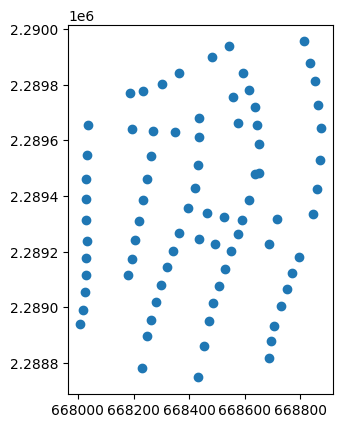

In [18]:
nodes.plot()

In [19]:
print(edges.shape)
edges.head(2)

(134, 4)


,u,v,key,geometry
0,0,3,0,"LINESTRING (668247.732 2288895.618, 668246.897..."
1,0,4,0,"LINESTRING (668247.732 2288895.618, 668246.897..."


<Axes: >

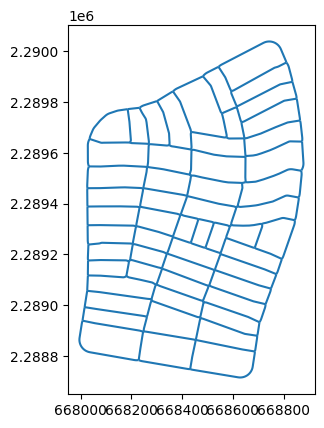

In [20]:
edges.plot()

In [21]:
nodes.to_file('../data/processed/nodes_fn_1.geojson')
edges.to_file('../data/processed/edges_fn_1.geojson')